# Fun with visualizing crystallinities

Make some synthetic thin sections of crystals with random shapes, sizes, orientations, and colors and then try to have people guess their proportions!



In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

export_path = r"C:\Users\jlubbers\Desktop\test_figures"

pandas version: 2.0.3
numpy version: 1.25.2
matplotlib version: 3.8.0


In [2]:
def PolyArea(x,y):
    """calculate the area of a polygon in euclidian space using the 
    shoelace formula: https://en.wikipedia.org/wiki/Shoelace_formula

    Args:
        x (array-like): x coordinate(s)
        y (array-like): y coordinate(s)

    Returns:
        scalar: area of polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

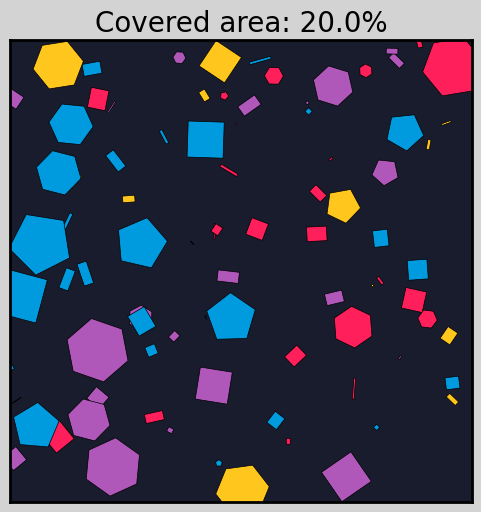

In [3]:
# make yer figure
fig, ax = plt.subplots(figsize=(6, 6))
# equal aspect ratio
ax.set_aspect(1)

# some colorblind friendly colors
colors = ["#009ADE", "#FF1F5B", "#AF58BA", "#FFC61E"]
# placeholders for stats at the end
shape_areas = []
shape_colors = []

# initial dummy shape. This will get populated with vertex
# coords later
all_shape_points = [
    np.array(
        [
            [82.1572774, 11.78134328],
            [96.48481532, 15.2095112],
            [100.69547861, 29.35892977],
            [90.54705432, 40.08018044],
            [76.18796674, 36.65201253],
            [71.97730345, 22.50259395],
            [82.12572774, 11.78134328],
        ]
    )
]
# container for patch objects
all_patches = []


# DESIRED COVERAGE
# becuase this is searching for overlap between objects, once we get above
# 0.7 this starts to take a while...not a lot of empty space so the chances
# of overlap are high.
area_fraction = 0.2

# simulate the crossing of polars with changing the bkgd color
# of the plot
plot_bkgd_color = "#191c2d"



# TOTAL AREA OF THE PLOT
total_area = 200 * 200
# control this by setting the axis limits at the end
# area of box multiplied by some threshold
area_limit = total_area * area_fraction

# this fills the plot until we meet the desired area coverage
while np.sum(shape_areas) <= area_limit:

    # generate some random colors and shapes for the shapes
    rand_n = np.random.randn()

    color_int = np.random.randint(1, 5)
    if color_int == 1:
        color = colors[0]
    elif color_int == 2:
        color = colors[1]
    elif color_int == 3:
        color = colors[2]
    elif color_int == 4:
        color = colors[3]

    # random x,y of shape origin
    xy = (np.random.uniform(-100, 100), np.random.uniform(-100, 100))

    # basically because this random number has a 50% chance to be above 0
    # our shape has a 50% chance of being rectangular and 50% to be something
    # else
    # make the matplotlib patch
    if rand_n > 0:
        patch = patches.RegularPolygon(
            xy,
            numVertices=np.random.randint(4, 7),
            radius=np.random.uniform(0.05, 15),
            orientation=np.random.uniform(0.05, 360),
            facecolor=color,
            edgecolor="k",
            linewidth=0.5,
        )

    else:
        patch = patches.Rectangle(
            xy=xy,
            width=np.random.uniform(0.05, 10),
            height=np.random.uniform(0.05, 10),
            angle=np.random.uniform(0.05, 360),
            facecolor=color,
            edgecolor="k",
            linewidth=0.5,
        )


    # Get the vertices 
    verts = patch.get_path().vertices
    # set up transformation object to get actual data coordinates
    trans = patch.get_patch_transform()
    # x,y in data coordinates for our vertices
    points = trans.transform(verts)
    # add them to the container of all generated points thus far
    all_shape_points.append(points)
    # add to the container of all patches generated thus far
    all_patches.append(patch)

    #calculate area
    shape_area = PolyArea(points[:, 0], points[:, 1])

    # check for overlapping points
    # for each patch thus far, check to see if the current iteration patch
    # has a point that is contained within it. If this is the case, dont
    # add it to the plot
    result = []
    for p in all_patches:
        result.append(p.contains_points(ax.transData.transform(points)))
    result = np.array(result).ravel()

    if any(result):
        pass


    # similarly, if the current iteration patch has any point from previous patches
    # contained inside it, don't add it to the plot
    elif any(
        patch.contains_points(ax.transData.transform(np.vstack(all_shape_points)))
    ):
        pass
    

    # finally, if there is no overlap, add it to the plot. 
    # FOR SOME REASON THERE IS STILL SOME MINOR OVERLAP, BUT overall the percentages
    # are quite good. 
    else:
        ax.add_patch(patch)

        shape_areas.append(shape_area)
        shape_colors.append(color)

    # once we meet the desired area coverage, break the loop! we done!
    if np.sum(shape_areas) > area_limit:
        break

# set the axis limits of the plot. This determines the total area specified above
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.grid('k--',lw = 0.25)

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)

ax.set_title(f'Covered area: {area_fraction*100}%',fontsize = 20)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
ax.spines[['top','right','left','bottom']].set_linewidth(2)
fig.set_facecolor('lightgray')
ax.set_facecolor(plot_bkgd_color)
plt.savefig(f"{export_path}\synthetic_thinsection_example.pdf")

In [4]:
results_df = pd.DataFrame({"color": shape_colors, "area": shape_areas}).set_index(
    "color"
)
print("RESULTS BREAKDOWN\nCOLOR   : % COVERAGE\n-----------------")
for color in colors:
    print(
        f"{color} : {np.round(100 *results_df.loc[color,'area'].sum() / (total_area),2)}"
    )
print(f"TOTAL   : {np.round(100*np.sum(shape_areas) / (total_area),2)}")

RESULTS BREAKDOWN
COLOR   : % COVERAGE
-----------------
#009ADE : 7.96
#FF1F5B : 3.31
#AF58BA : 5.79
#FFC61E : 2.94
TOTAL   : 20.0


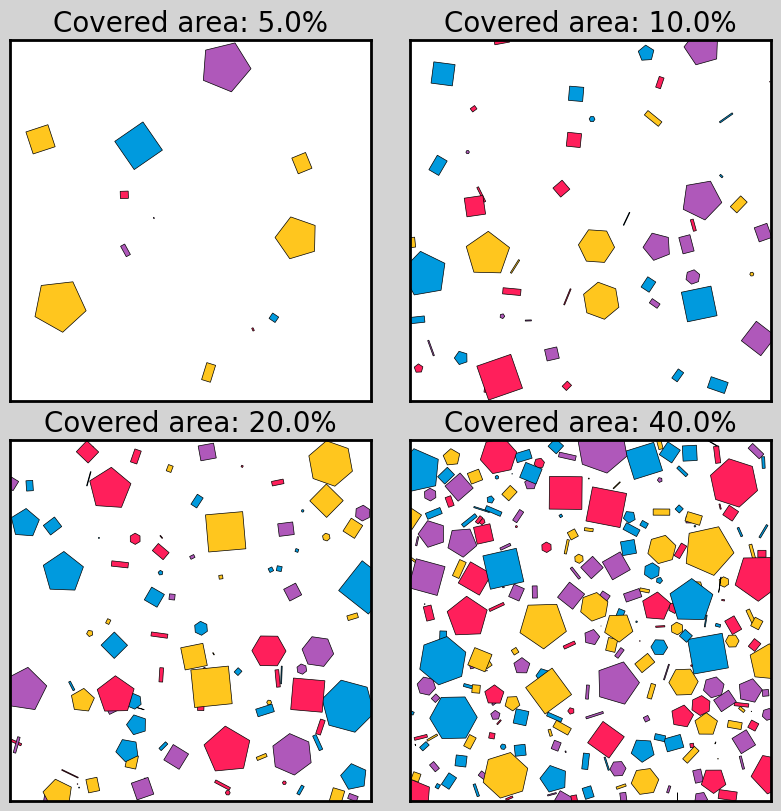

In [5]:
fig, ax = plt.subplots(2,2, figsize = (8,8),layout = 'constrained')
axes = ax.ravel()
coverages = np.array([0.05,0.1,0.2,0.4])
colors = ["#009ADE", "#FF1F5B", "#AF58BA", "#FFC61E"]

for a, coverage, in zip(axes, coverages):
    a.set_aspect(1)


    shape_areas = []
    shape_colors = []
    all_shape_points = [
        np.array(
            [
                [82.1572774, 11.78134328],
                [96.48481532, 15.2095112],
                [100.69547861, 29.35892977],
                [90.54705432, 40.08018044],
                [76.18796674, 36.65201253],
                [71.97730345, 22.50259395],
                [82.12572774, 11.78134328],
            ]
        )
    ]
    all_patches = []

    area_fraction = coverage
    area_limit = (200 * 200) * area_fraction  # area of box multiplied by some threshold
    while np.sum(shape_areas) <= area_limit:


        rand_n = np.random.randn()

        color_int = np.random.randint(1, 5)
        if color_int == 1:
            color = colors[0]
        elif color_int == 2:
            color = colors[1]
        elif color_int == 3:
            color = colors[2]
        elif color_int == 4:
            color = colors[3]

        xy = (np.random.uniform(-100, 100), np.random.uniform(-100, 100))
        if rand_n > 0:
            patch = patches.RegularPolygon(
                xy,
                numVertices=np.random.randint(4, 7),
                radius=np.random.uniform(0.05, 15),
                orientation=np.random.uniform(0.05, 360),
                facecolor=color,
                edgecolor="k",
                linewidth=0.5,
            )

        else:
            patch = patches.Rectangle(
                xy=xy,
                width=np.random.uniform(0.05, 10),
                height=np.random.uniform(0.05, 10),
                angle=np.random.uniform(0.05, 360),
                facecolor=color,
                edgecolor="k",
                linewidth=0.5,
            )
        
        shape_verts = patch.get_path().vertices
        verts = patch.get_path().vertices
        trans = patch.get_patch_transform()
        points = trans.transform(verts)
        all_shape_points.append(points)
        all_patches.append(patch)


        shape_area = PolyArea(points[:, 0], points[:, 1])
        result = []
        for p in all_patches:
            result.append(p.contains_points(a.transData.transform(points)))
        result = np.array(result).ravel()

        if any(result):
            pass
        elif any(patch.contains_points(a.transData.transform(np.vstack(all_shape_points)))):
            pass
        
        else:


            a.add_patch(patch)

            shape_areas.append(shape_area)
            shape_colors.append(color)
            


        if np.sum(shape_areas) > area_limit:
            break

    a.set_xlim(-100, 100)
    a.set_ylim(-100, 100)

    a.set_title(f'Covered area: {coverage*100}%',fontsize = 20)
    a.xaxis.set_tick_params(labelbottom=False)
    a.yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    a.set_xticks([])
    a.set_yticks([])
    a.spines[['top','right','left','bottom']].set_linewidth(2)
fig.set_facecolor('lightgray')

plt.savefig(f"{export_path}\synthetic_thinsection_panel_example.pdf")
